# Metric learning

Задание 6

Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE

import tensorflow_datasets as tfds

In [45]:
full_y, full_x = tfds.as_numpy(tfds.load(
    'lfw',
    split='train',    
    batch_size=-1,
    as_supervised=True
))

In [58]:
train_x = full_x[:10000,...]
train_y = full_y[:10000,...]
test_x = full_x[10000:,...]
test_y = full_y[10000:,...]

In [62]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(10000, 250, 250, 3)
(10000,)
(3233, 250, 250, 3)
(3233,)


In [60]:
train_x = train_x.reshape(-1, 250, 250, 3).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 250, 250, 3).astype(np.float32) / 255.

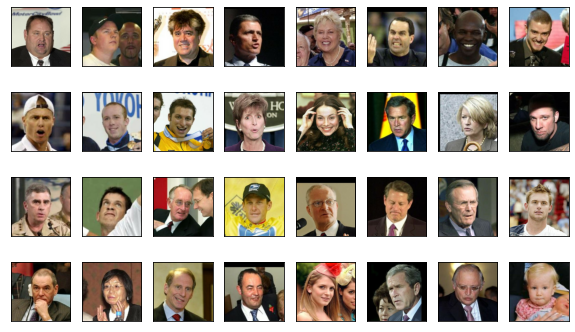

In [63]:
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,:])
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание модели CNN

In [ ]:
try:
    model = tf.keras.models.load_model("lfw_model")
except IOError:    
    print('Create model')

In [64]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [65]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [66]:
BATCH_SIZE = 64
NUM_EPOCHS = 4

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Подготовка к обучению

In [67]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [71]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 2 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 101.607666015625
[2] Loss: 0.0
[4] Loss: 0.19855354726314545
[6] Loss: 3.9496734142303467
[8] Loss: 3.487856388092041
[10] Loss: 9.68082332611084
[12] Loss: 0.8184942603111267
[14] Loss: 0.35439056158065796
[16] Loss: 0.0
[18] Loss: 0.7208988070487976
[20] Loss: 0.03429129719734192
[22] Loss: 107.04109191894531
[24] Loss: 0.6517797112464905
[26] Loss: 1.7376775741577148
[28] Loss: 1.302988052368164
[30] Loss: 7.753204345703125
[32] Loss: 0.049510158598423004
[34] Loss: 0.025491751730442047
[36] Loss: 0.0
[38] Loss: 0.0
[40] Loss: 0.0
[42] Loss: 0.0
[44] Loss: 0.0
[46] Loss: 0.12510336935520172
[48] Loss: 0.10434024035930634
[50] Loss: 10.075511932373047
[52] Loss: 0.8312522768974304
[54] Loss: 0.68282550573349
[56] Loss: 0.7312612533569336
[58] Loss: 0.2588126063346863
[60] Loss: 0.21033677458763123
[62] Loss: 0.09202898293733597
[64] Loss: 0.8576034903526306
[66] Loss: 0.03421840816736221
[68] Loss: 21.99777603149414
[70] Loss: 0.003371861996129155
[72] Loss: 0.3262590765953

[584] Loss: 0.1282835602760315
[586] Loss: 0.012352675199508667
[588] Loss: 6.152887362986803e-05
[590] Loss: 31.11723518371582
[592] Loss: 0.1138811707496643
[594] Loss: 0.0
[596] Loss: 0.5384712815284729
[598] Loss: 0.1199796199798584
[600] Loss: 0.06273701786994934
[602] Loss: 0.448287695646286
[604] Loss: 0.023653224110603333
[606] Loss: 0.4526262879371643
[608] Loss: 0.1691483110189438
[610] Loss: 0.46672505140304565
[612] Loss: 0.0034790653735399246
[614] Loss: 0.0
[616] Loss: 0.0
[618] Loss: 0.0
[620] Loss: 0.0
[622] Loss: 0.0
[624] Loss: 0.0
Wall time: 2h 10min 48s


## Сохранение модели

## Получение эмбеддингов для тестовой выборки

In [78]:
test_embs = model.predict(test_x)

In [75]:
model.save('lfw_model')

INFO:tensorflow:Assets written to: lfw_model\assets


INFO:tensorflow:Assets written to: lfw_model\assets


## Функция для визуализации эмбеддингов

In [76]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

## Тестирование на новых данных

In [83]:
!pip install scikit-image

In [84]:
from skimage.transform import resize
import imageio

In [102]:
def load_and_prepare_image(fpath):   
    
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250), order=3, mode='reflect', anti_aliasing=True)    
    img = np.reshape(img, (250, 250, 3))
    return img



In [115]:
img_1 = load_and_prepare_image('Aaron_Peirsol_0001.jpg')
img_2 = load_and_prepare_image('Aaron_Peirsol_0002.jpg')
img_3 = load_and_prepare_image('Aaron_Peirsol_0003.jpg')
img_4 = load_and_prepare_image('Aaron_Peirsol_0004.jpg')
other_img_1 = load_and_prepare_image('Adam_Ant_0001.jpg')


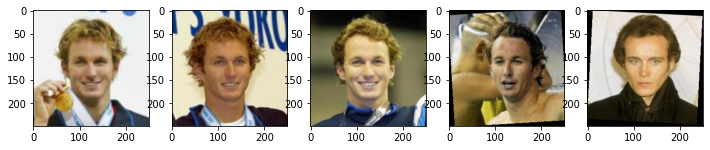

In [116]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(img_1[:,:,:])
ax = fig.add_subplot(1, 5, 2)
ax.imshow(img_2[:,:,:])
ax = fig.add_subplot(1, 5, 3)
ax.imshow(img_3[:,:,:])
ax = fig.add_subplot(1, 5, 4)
ax.imshow(img_4[:,:,:])
ax = fig.add_subplot(1, 5, 5)
ax.imshow(other_img_1[:,:,:])
plt.show()

## Получение эмбеддингов для новых данных

In [125]:
new_embs = model(np.stack((other_img_1, img_2, img_3,img_4,img_1), axis=0))

## Вычисление расстояний между эмбеддингами

In [126]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

other_emb5 = new_embs[4,:]

print('emb1 <-> emb2: ', diff(emb1, emb2))
print('emb2 <-> emb3: ', diff(emb2, emb3))
print('emb1 <-> emb3: ', diff(emb1, emb3))
print('emb1 <-> other_emb5: ', diff(emb1, other_emb5))

emb1 <-> emb2:  22.221984370336255
emb2 <-> emb3:  21.6270715680458
emb1 <-> emb3:  21.90760056798746
emb1 <-> other_emb5:  25.450674183727433


In [124]:
len(train_ds)

625